In [8]:
import opendatasets as od

data_path = 'https://www.kaggle.com/datasets/abdallahwagih/kvasir-dataset-for-classification-and-segmentation'
od.download(data_path)

Skipping, found downloaded files in "./kvasir-dataset-for-classification-and-segmentation" (use force=True to force download)


# 1. Prepare data

In [1]:
# Read image and mask paths
image_paths = []
mask_paths = []
import os

images_root = './kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/images'
masks_root = './kvasir-dataset-for-classification-and-segmentation/kvasir-seg/Kvasir-SEG/masks'

for image, mask in zip(os.listdir(images_root), os.listdir(masks_root)):
    image_paths.append(os.path.join(images_root, image))
    mask_paths.append(os.path.join(masks_root, mask))

### Try converting images and masks to their true channel and check number of channels of images and masks

In [2]:
from PIL import Image

print('Image: ', Image.open(image_paths[0]).convert('RGB').getbands())
print('Mask: ', Image.open(mask_paths[0]).convert('L').getbands())

Image:  ('R', 'G', 'B')
Mask:  ('L',)


### Check the shape of images and masks

In [3]:
import numpy as np

print('Images: ', np.array(Image.open(image_paths[0]).convert('RGB')).shape)
print('Masks: ', np.array(Image.open(mask_paths[0]).convert('L')).shape)

Images:  (530, 571, 3)
Masks:  (530, 571)


### Show examples of data
#### Bài tập 1: Plot ảnh từ dataset ra, đối tượng cần load là 1 cặp mẫu dữ liệu, mỗi cặp bao gồm 1 image và 1 mask

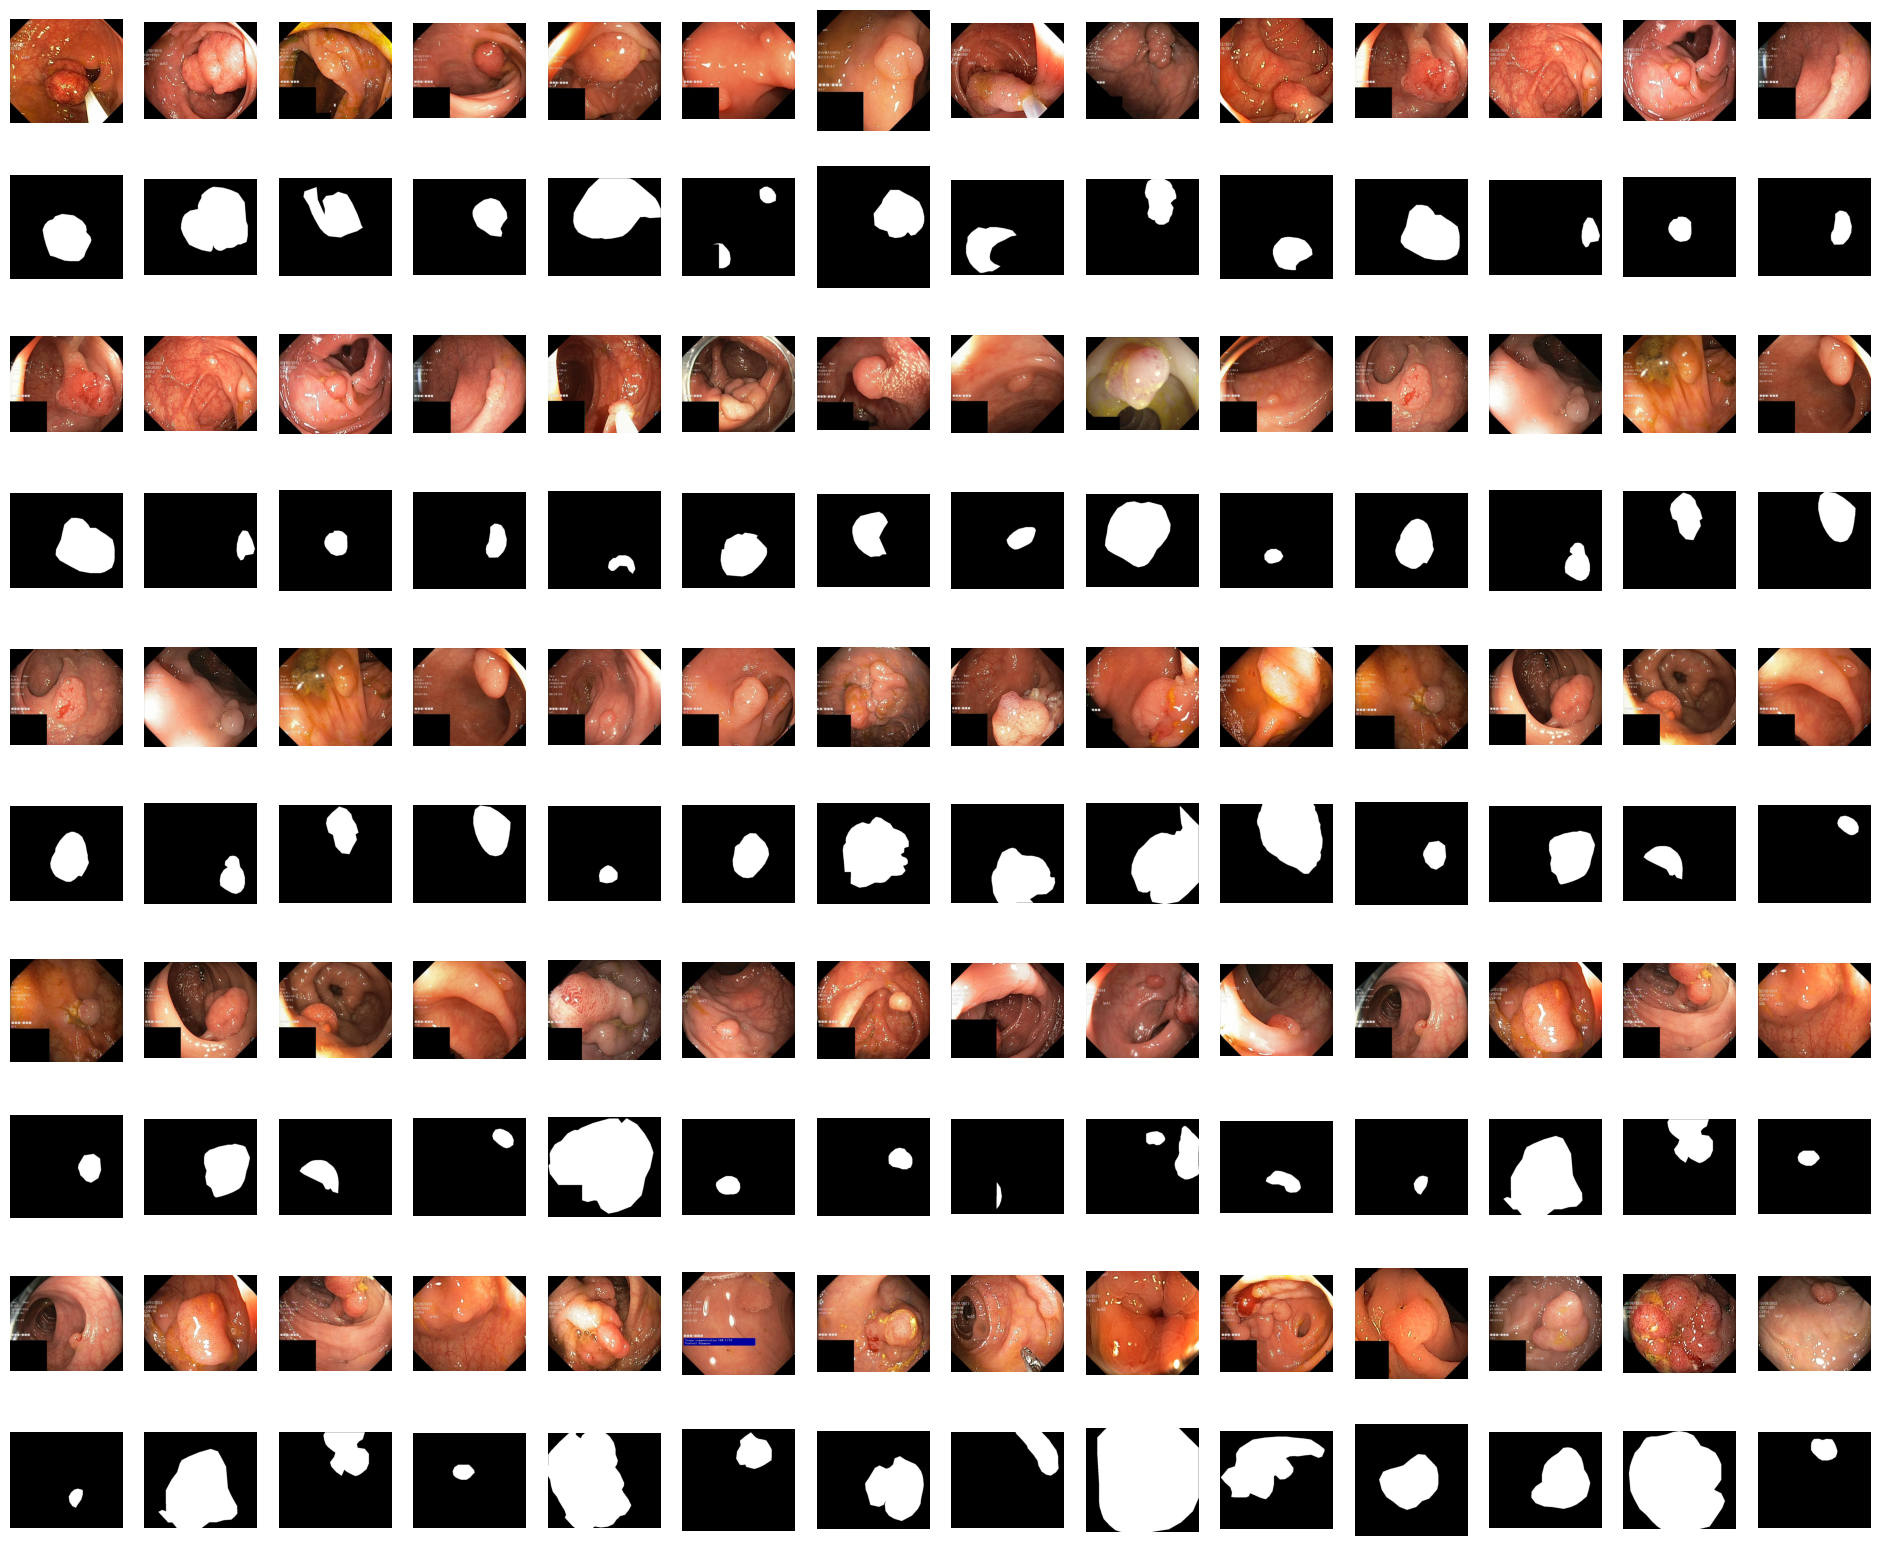

In [4]:
import matplotlib.pyplot as plt
def Visualize_Data():
    fig, axes = plt.subplots(10, 14, figsize=(24, 20))
    
    for i in range(0, 10, 2):
        for j in range(0, 14):
            num = i // 2 * 10 + j
            image = Image.open(image_paths[num])
            mask = Image.open(mask_paths[num])
            
            axes[i, j].imshow(image)
            axes[i, j].axis('off')
            
            axes[i + 1, j].imshow(mask)
            axes[i + 1, j].axis('off')
    plt.show()

Visualize_Data()
            

### Split data into three sets

In [5]:
from sklearn.model_selection import train_test_split
# seed = 0
val_size = 0.2
test_size = 0.25
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    image_paths,
    mask_paths,
    test_size=val_size,
    random_state=42,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=42,
    shuffle=is_shuffle
)

print('Train: ', len(X_train))
print('Val: ', len(X_val))
print('Test: ', len(X_test))

Train:  600
Val:  200
Test:  200


### Create Kvasir Dataset

In [6]:
from torch.utils.data import Dataset, DataLoader

class KvasirDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    # Load image and mask
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image, mask = self.transform(image, mask)
            
        return image, mask

### Calculate mean and std of the dataset

In [7]:
# Create non transform dataset
full_data = KvasirDataset(image_paths, mask_paths)
img_data = []
for img, _ in full_data:
    img_array = np.array(img.resize((224, 224))) / 255.0
    img_data.append(img_array)
    
img_data = np.array(img_data)

# Calculate mean and std
mean = np.mean(img_data, axis=(0, 1, 2))
std = np.std(img_data, axis=(0, 1, 2))

print('Mean: ', mean)
print('Std: ', std)

Mean:  [0.55714883 0.32170294 0.23581956]
Std:  [0.31774015 0.22082197 0.18651856]


### Data transform and augmentation
#### Bài tập 2: Hoàn thiện các phép biến đổi dữ liệu
Trong bài tập này, bạn sẽ hoàn thiện các phép biến đổi (transforms) cho ảnh và mask. Các phép biến đổi này sẽ giúp chuẩn bị dữ liệu trước khi đưa vào mô hình học sâu. Gợi ý: dùng các hàm trong "transforms"

In [9]:
import torchvision.transforms as transforms
import torch

# Define a class transform for image and mask
class CustomTransform:
    def __init__(self, image_transform, mask_transform):
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __call__(self, image, mask):
        seed = torch.random.initial_seed()
        torch.manual_seed(seed)
        image = self.image_transform(image)

        torch.manual_seed(seed)
        mask = self.mask_transform(mask)

        return image, mask

# Train Image transforms
train_image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # TODO: Chuẩn hóa ảnh với giá trị mean và std, các giá trị mean và std dùng lại mean và std đã tính ở trên
    transforms.Normalize(mean=[0.55714883, 0.32170294, 0.23581956], std=[0.31774015, 0.22082197, 0.18651856])
])

# Train Mask Transforms
train_mask_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # TODO: Chuyển mask thành nhị phân, gồm các giá trị 0 và 1
    transforms.Lambda(lambda x: (x > 0.5).float())
])

# Val Image transforms
val_image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # TODO: Chuẩn hóa ảnh với giá trị mean và std, các giá trị mean và std dùng lại mean và std đã tính ở trên
    transforms.Normalize(mean=[0.55714883, 0.32170294, 0.23581956], std=[0.31774015, 0.22082197, 0.18651856])
])

# Val Mask transforms
val_mask_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # TODO: Chuyển mask thành nhị phân, gồm các giá trị 0 và 1
    transforms.Lambda(lambda x: (x > 0.5).float())
])

# Transforms dictionary
data_transforms = {
    'train': CustomTransform(train_image_transforms, train_mask_transforms),
    'val': CustomTransform(val_image_transforms, val_mask_transforms),
}


### Create dataset

In [10]:
# Create datasets
train_dataset = KvasirDataset(
    X_train,
    y_train,
    transform=data_transforms['train']
)

val_dataset = KvasirDataset(
    X_val,
    y_val,
    transform=data_transforms['val']
)

test_dataset = KvasirDataset(
    X_test,
    y_test,
    transform=data_transforms['val']
)

### Make dataloader

In [11]:
# Create dataloaders
train_batch_size = 8
test_batch_size = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

### Show batch

In [12]:
import torchvision

train_features, train_labels = next(iter(train_loader))

# Use torchvision to display a grid of images
def show_batch(images, masks):
    grid_images = torchvision.utils.make_grid(images, nrow=4, normalize=True)
    grid_masks = torchvision.utils.make_grid(masks, nrow=4, normalize=True)

    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(grid_images, (1, 2, 0)), )
    plt.show()
    
    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(grid_masks, (1, 2, 0)), )
    plt.show()

In [13]:
# Check the shape of the images and masks
train_features[0].shape

torch.Size([3, 224, 224])

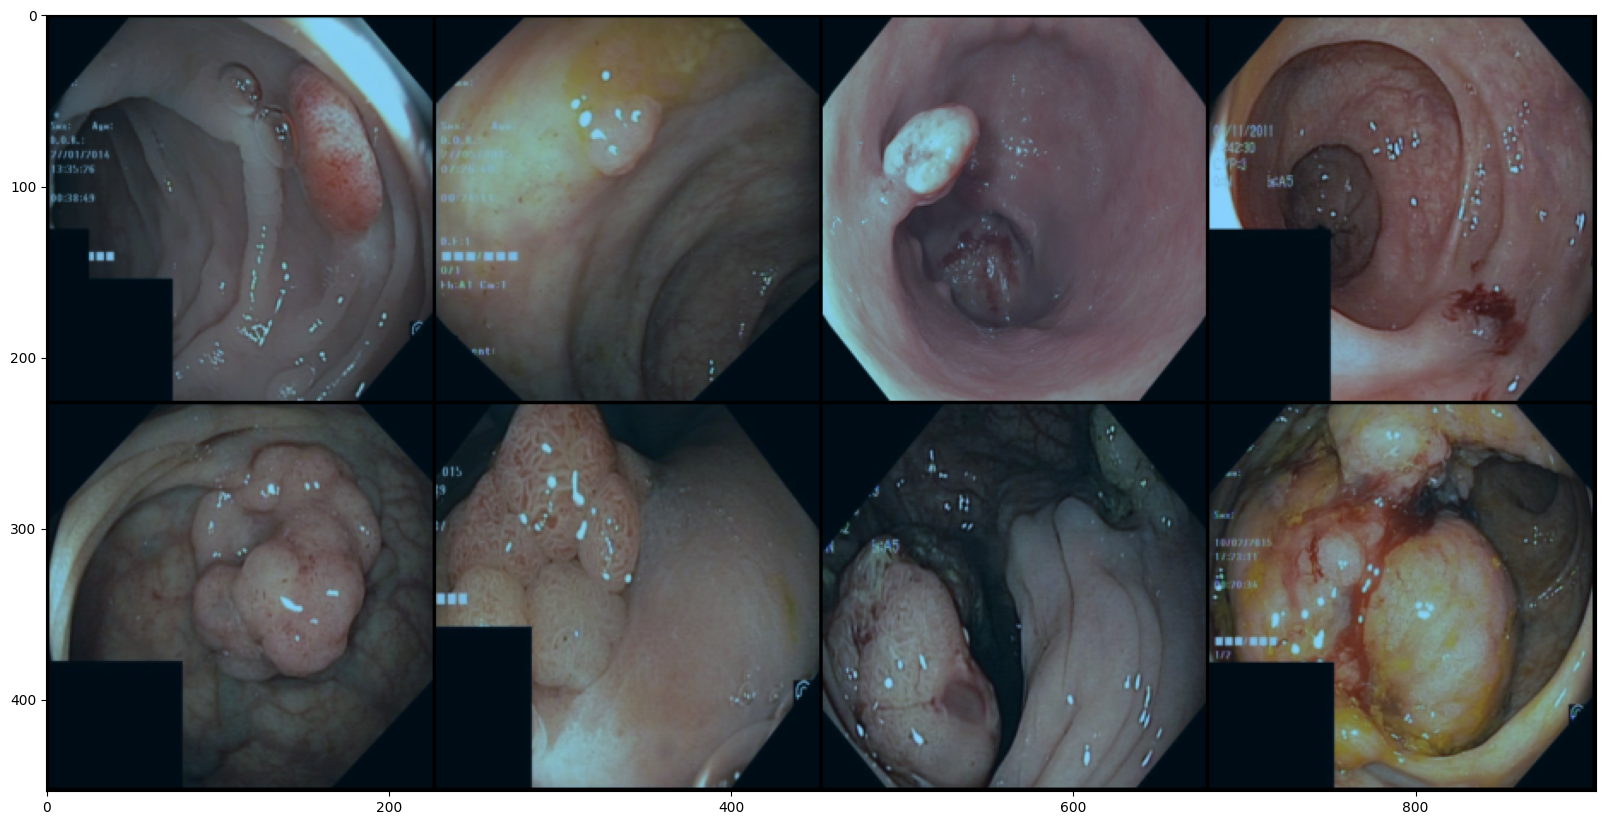

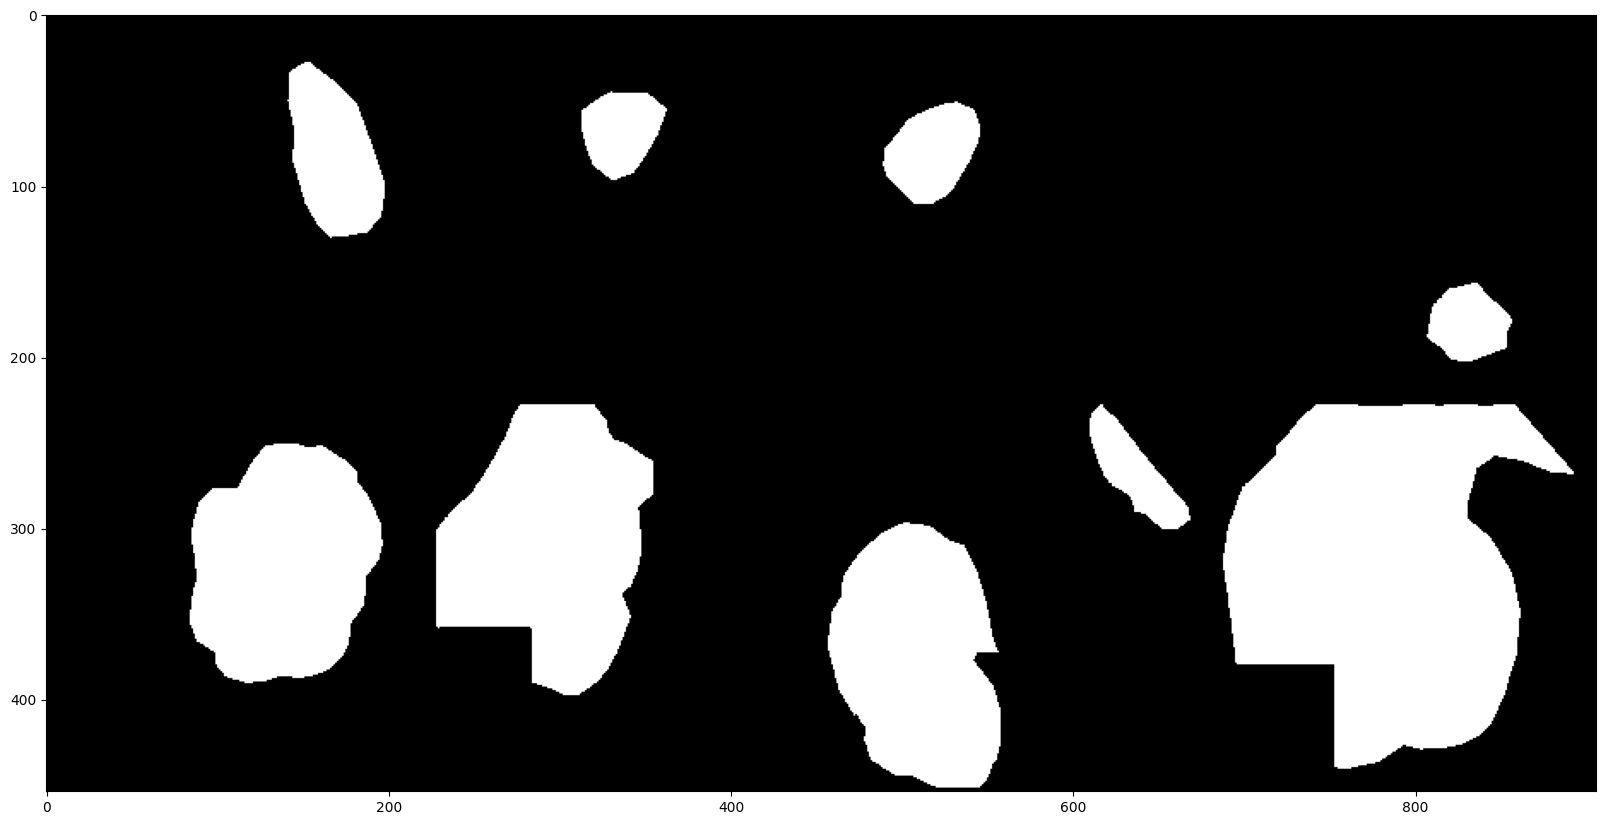

In [14]:
# Display a batch of images and masks
show_batch(train_features, train_labels)

In [15]:
# Check device availability
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. Model

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

#### Bài tập 3: Hoàn thành các đoạn code sau theo gợi ý

In [ ]:
# Define the convolutional block
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

# Define the ConvRelu
class ConvRelu(nn.Module):
    def __init__(self, in_: int, out: int):
        super().__init__()
        # TODO: Tạo một lớp convolution sử dụng hàm conv3x3 ở trên
        # TODO: Tạo một lớp ReLU activation với inplace=True

    def forward(self, x):
        # TODO: Áp dụng lớp convolution lên input x
        # TODO: Áp dụng activation function lên output từ convolution
        return x

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlock, self).__init__()
        # TODO: Lưu lại giá trị in_channels

        # TODO: Nếu is_deconv là True, sử dụng ConvTranspose2d để tăng kích thước
        if is_deconv:
            self.block = nn.Sequential(
                # TODO: Thêm một lớp ConvRelu với in_channels và middle_channels
                # TODO: Thêm một lớp ConvTranspose2d với middle_channels và out_channels
                # TODO: Thêm một lớp ReLU activation với inplace=True
            )
        # TODO: Nếu is_deconv là False, sử dụng Upsample để tăng kích thước
        else:
            self.block = nn.Sequential(
                # TODO: Thêm một lớp Upsample với scale_factor=2 và mode='bilinear'
                # TODO: Thêm một lớp ConvRelu với in_channels và middle_channels
                # TODO: Thêm một lớp ConvRelu với middle_channels và out_channels
            )

    def forward(self, x):
        return self.block(x)

In [ ]:

# TODO: Định nghĩa lớp UNet11 kế thừa từ nn.Module
class UNet11(nn.Module):
    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes: số lượng lớp đầu ra
        :param num_filters: số lượng bộ lọc sử dụng trong mạng
        :param pretrained: sử dụng mô hình VGG11 có trọng số pre-trained hay không
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        # TODO: Lưu lại số lượng lớp đầu ra

        # TODO: Kiểm tra nếu pretrained=True, sử dụng mô hình VGG11 với trọng số có sẵn
        if pretrained:
            self.encoder = models.vgg11(weights=models.vgg.VGG11_Weights.DEFAULT).features
        else:
            self.encoder = models.vgg11().features

        # TODO: Khởi tạo hàm kích hoạt ReLU
        # TODO: Xây dựng các khối convolutional từ các lớp trong VGG11
        self.conv1 = nn.Sequential(
            self.encoder[0],
            # TODO: Thêm hàm kích hoạt ReLU
        )

        self.conv2 = nn.Sequential(
            self.encoder[3],
            # TODO: Thêm hàm kích hoạt ReLU
        )

        # TODO: Tiếp tục xây dựng các khối convolutional cho conv3, conv4, conv5
        self.conv3 = nn.Sequential(
            self.encoder[6],
            # TODO: Thêm hàm kích hoạt ReLU
            self.encoder[8],
            # TODO: Thêm hàm kích hoạt ReLU
        )

        # TODO: Xây dựng khối center và decoder tương ứng
        self.center = DecoderBlock(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv=is_deconv)
        
        # TODO: Xây dựng các lớp decoder dec5, dec4, dec3, dec2, dec1 theo kiến trúc U-Net

        # TODO: Xây dựng lớp final convolution
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        # TODO: Thực hiện forward pass theo thứ tự các tầng conv1 -> conv5, pool giữa các tầng
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        # TODO: Tiếp tục cho đến conv5

        # TODO: Truyền qua tầng center
        center = self.center(self.pool(conv5))

        # TODO: Ghép nối (concat) các đặc trưng từ encoder với decoder theo từng tầng
        dec5 = self.dec5(torch.cat([center, conv5], 1))
        # TODO: Tiếp tục với dec4, dec3, dec2, dec1

        # TODO: Kiểm tra nếu num_classes > 1, sử dụng log_softmax, ngược lại sử dụng conv đầu ra
        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)

        return x_out

In [ ]:
# Create the model
from torchsummary import summary

model = UNet11(pretrained=True)
model.to(device)
summary(model, (3, 224, 224))

## IOU metric
For quality assessment, we will use the IoU (intersection over union) metric defined as:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

### Examples:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


#### Intersection and union:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

#### Bài tập 4: Hoàn thành hàm IOU bên dưới

In [ ]:
def iou_pytorch(outputs, labels):
    outputs = outputs.squeeze().byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze().byte()

    SMOOTH = 1e-8

    # TODO: Tính toán phần giao nhau giữa outputs và labels
    # intersection = ...

    # TODO: Tính toán phần hợp giữa outputs và labels
    # union = ...

    # TODO: Tính toán IoU theo công thức iou theo công thức (intersection + SMOOTH) / (union + SMOOTH)
    # iou = ...
    return iou


## Loss function

To start the training of our model, we will implement a loss function:\
**Binary cross-enthropy loss (BCE)**

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ is our target and $\hat y$ is an output of the model. $\sigma$ is a logistic function 



In [ ]:
import torch.nn as nn

nn.BCEWithLogitsLoss()

# 3. Train

In [ ]:
# Function to denormalize image
def de_normalize(img, mean=mean, std=std):
    result = img * std + mean
    result = np.clip(result, 0.0, 1.0)
    
    return result

In [ ]:
# Function to display the result
@torch.inference_mode()
def display_prediction(model, image, target):
    model.eval()
    img = image[None,...].to(device)
    output = model(img)
    pred = (torch.sigmoid(output.squeeze()) > 0.5).to(int)


    plt.figure(figsize=(10, 5))

    plt.subplot(1,3,1)
    plt.axis('off')
    plt.title("Input Image")
    plt.imshow(de_normalize(image.numpy().transpose(1,2,0)))

    plt.subplot(1,3,2)
    plt.axis('off')
    plt.title("Prediction")
    plt.imshow(pred.cpu().squeeze(), cmap='gray')

    plt.subplot(1,3,3)
    plt.axis('off')
    plt.title("Ground Truth")
    plt.imshow(target.numpy().transpose(1, 2, 0), cmap='gray')

    plt.show()

In [ ]:
# Choose one set of image, mask in train set to display
idx = np.random.randint(0, len(train_dataset) - 1)
display_image = train_dataset[idx][0]
display_mask = train_dataset[idx][1]

In [ ]:
# Function to evaluate model
def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    val_IOU = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            total += labels.size(0)
            predict_labels = (torch.sigmoid(outputs.squeeze()) > 0.5).to(int)
            val_IOU += iou_pytorch(predict_labels, labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_IOU = val_IOU / total
    return val_loss, val_IOU

In [ ]:
# Function to train model
def train(model, train_loader, val_loader, criterion, optimizer, max_epoch=50, output_path='best_model.pt'):
    # save progress
    train_losses = []
    val_losses = []
    train_IOUs = []
    val_IOUs = []
    best_IOU = 0.0
    
    # Train
    for epoch in range(max_epoch):
        model.train()

        running_loss = 0.0
        running_IOU = 0
        total = 0
        
        for i, (inputs, labels) in enumerate(train_loader, 0):
            # Move inputs and labels to the device
            inputs, labels = inputs.to(device), labels.to(device) 

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            
            # Calculate IOU
            total += labels.size(0)
            predict_labels = (torch.sigmoid(outputs.squeeze()) > 0.5).to(int)

            running_IOU += iou_pytorch(predict_labels, labels).sum().item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
        epoch_loss = running_loss / len(train_loader)
        epoch_IOU = running_IOU / total
        val_loss, val_IOU = evaluate(model, val_loader, criterion)
        # Save best model
        if val_IOU > best_IOU:
            best_IOU = val_IOU
            model_scripted = torch.jit.script(model) # Export to TorchScript
            model_scripted.save(output_path) # Save
        
        print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, IOU: {epoch_IOU:.2f}, Val Loss: {val_loss:.4f}, Val IOU: {val_IOU:.2f}")
        display_prediction(model, display_image, display_mask)
        

        # Save for plot
        train_losses.append(epoch_loss)
        train_IOUs.append(epoch_IOU)
        val_losses.append(val_loss)
        val_IOUs.append(val_IOU)
        
    return [train_losses, val_losses, train_IOUs, val_IOUs]
        

In [ ]:
# Clear the GPU memory just in case
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

In [ ]:
# Train the model
max_epoch = 20
lr = 4e-5
weight_decay = 1e-4
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay = weight_decay)
history_bce = train(model, train_loader, val_loader, criterion, optimizer, max_epoch, 'best_unet11_model.pt')